# Summary Report for Eye Projects

Darvin Yi (darvinyi[at]Stanford[dot]edu)
Carson Lam (carsonl[at]Stanford[dot]edu)

We can give the summary reports for the following projects:
- Data Preprocessing
- Exudate/Microaneurysm Segmentation
- Diabetic Retinopathy Classification
- Sliding Window Abnormality Detection

# Data Preprocessing

We do a few things, but we'll focus on showing off the following:
- Tight Cropping
- Adaptive Histogram Equalization

## Tight Cropping

Most of the image will be black background.  Thus, we want to crop very tightly around the eye as much as possible to give the network the most information as possible.

In [1]:
import numpy as np
import scipy.misc
from skimage.filters import threshold_otsu
from skimage import measure,exposure

import matplotlib.pyplot as plt
%matplotlib inline

# Function to do cropping
def tight_crop(img,size=None):
    img_gray = np.mean(img, 2)
    img_bw = img_gray > threshold_otsu(img_gray)
    img_label = measure.label(img_bw, background=0)
    largest_label = np.argmax(np.bincount(img_label.flatten())[1:]) + 1
    img_circ = (img_label == largest_label)
    img_xs = np.sum(img_circ, 0)
    img_ys = np.sum(img_circ, 1)
    xs = np.where(img_xs > 0)
    ys = np.where(img_ys > 0)
    y_lo = np.min(ys)
    y_hi = np.max(ys)
    x_lo = np.min(xs)
    x_hi = np.max(xs)
    img_crop = img[y_lo:y_hi, x_lo:x_hi, :]
    return img_crop

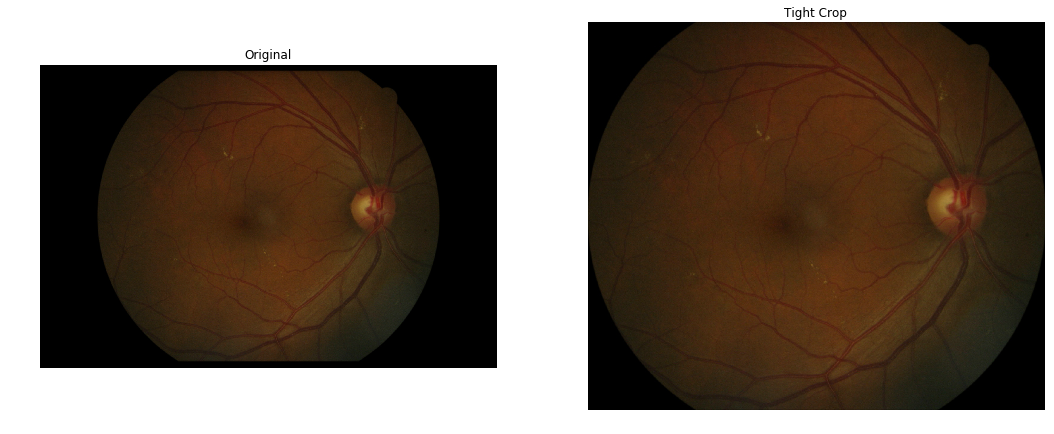

In [2]:
# Filepath
path_img = "figures/examples/C0021833.jpg"

# Reading in Image
img = scipy.misc.imread(path_img)
img = img.astype(np.float32)
img /= 255

# Cropping Image
img_crop = tight_crop(img)

# Plotting
plt.rcParams['figure.figsize'] = [18,12]
fig,ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(img_crop)
ax[1].axis('off')
ax[1].set_title('Tight Crop')

## Adaptive Histogram Equalization

Basically, working with 8-bit images where the signal is quite subtle, we chose to put each channel through an adaptive histogram equalization to make sure interesting features were not lost.

In [3]:
# Function for AHE
def channelwise_ahe(img):
    img_ahe = img.copy()
    for i in range(img.shape[2]):
        img_ahe[:,:,i] = exposure.equalize_adapthist(img[:,:,i], clip_limit=0.03)
    return img_ahe

C:\Users\yidar\AppData\Local\Continuum\Anaconda2\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


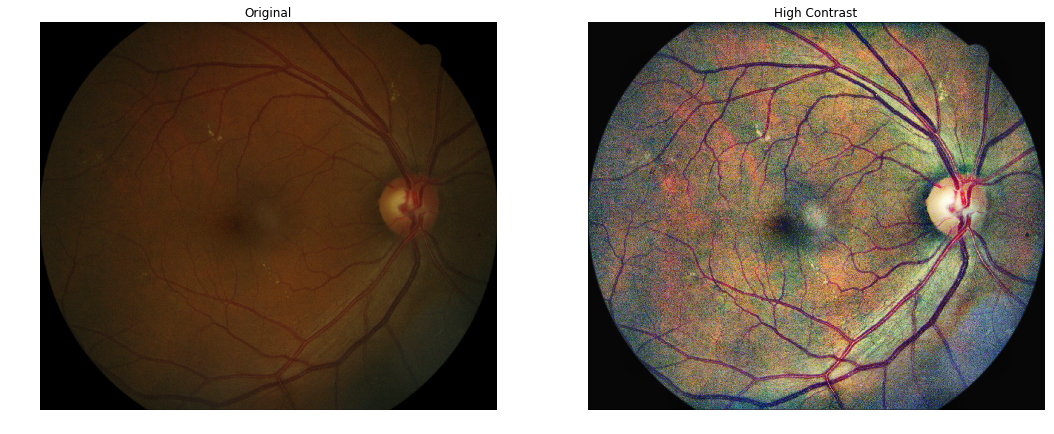

In [4]:
# Do Contrast Enhancement
img_ahe = channelwise_ahe(img_crop)

# Plotting
plt.rcParams['figure.figsize'] = [18,12]
fig,ax = plt.subplots(1,2)
ax[0].imshow(img_crop)
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(img_ahe)
ax[1].axis('off')
ax[1].set_title('High Contrast')

To see why this contrast enhancement is helpful, we can look at microaneurysms.

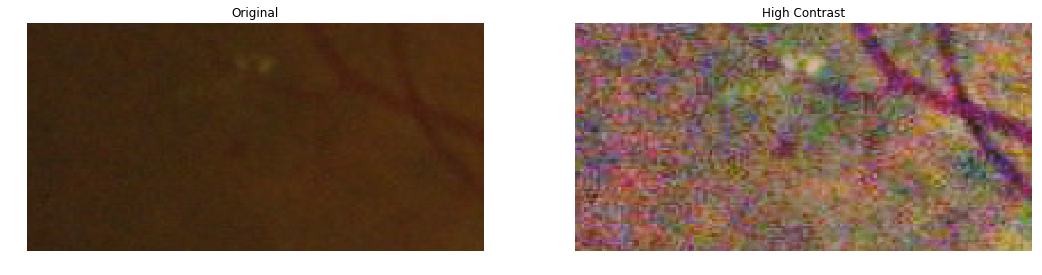

In [5]:
img_MA = img_crop[825:925,250:450,:]
img_MA_ahe = img_ahe[825:925,250:450,:]

# Plotting
plt.rcParams['figure.figsize'] = [18,12]
fig,ax = plt.subplots(1,2)
ax[0].imshow(img_MA)
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(img_MA_ahe)
ax[1].axis('off')
ax[1].set_title('High Contrast')

Even zoomed in, it's hard to tell the microaneurysms in the original image.  However, in the high contrast image, it's a little easier.  Easier for the human will most likely be easier for the machine.

## Exudate/Microaneurysm Segmentation

### Data: A Color Fundus Image Database

The data comes from a French group called [ADCIS](http://www.adcis.net/en/Download-Third-Party/E-Ophtha.html).  They apparently work on biomedical image analysis.

The main data that we have to work with has the following images:
- 34 Patients with Exudates labeled as binary mask
- 67 Patients with Microaneurysms labeled as binary mask
- 100+ Normal Patients

### Preliminary work

We simply follow a simply architecture set up like the one shown by [Long *et. al.*](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf).  We just put a few `conv2d_tranpose` layers on the end of [GoogLe Net](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf) and we already get good results.

### Exudates

Even with 34 patients and less than 1 hr training on a single gpu using default network parameters, we can segment out exudates pretty well.  Here are some examples from the validation set (i.e. never touched by training algorithm).  Care was also taken to make sure training/validation sets were separated by patient.

Every image below is formatted the same way.
- The left image is a grayscaled version of the original image.
- The right image is the original image overlayed with the grount truth segmentation (red=1, blue=0)
- The middle image is the original image overlayed with our predicted softmax probability values represented by the jet-colormap going from colder blue colors for less probable and hotter red colors for more probable of being a pixel of interest.

![](C:\Users\yidar\Desktop\candle\reports\figures\EX-seg\C0021833.h5.png)

![](C:\Users\yidar\Desktop\candle\reports\figures\EX-seg\C0021834.h5.png)

![](C:\Users\yidar\Desktop\candle\reports\figures\EX-seg\C0021835.h5.png)

![](C:\Users\yidar\Desktop\candle\reports\figures\EX-seg\C0021836.h5.png)

![](C:\Users\yidar\Desktop\candle\reports\figures\EX-seg\C0025307.h5.png)

![](C:\Users\yidar\Desktop\candle\reports\figures\EX-seg\DS000OTS.h5.png)

### Microaneurisms

These were a bit trickier.  To be honest, the exudates will train even without the histogram normalization.  The microaneurisms will not train without the adaptive histogram equalization.  They also take about twice the time to train as the exudates.  This is because the features are MUCH MUCH smaller.